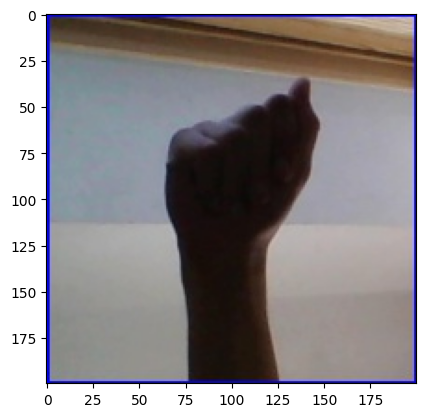

In [196]:
import cv2 as cv
from PIL import Image
import os

import matplotlib.pyplot as plt
import numpy as np

csv_path = 'data/model/keypoints_from_data.csv'
baseData = 'data/archive/asl_alphabet_train/'

sign = 'A'
first = baseData + sign + '/A1.jpg'
imgstmp = []

class SignCategory:
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __str__(self):
        return "<Label: " + self.label + "\n" + str(self.data) + ">"

categories = []
imgsAndLabels = []

for subdir, dir,files in os.walk(baseData):
    if subdir == baseData:
        continue
    
    label = subdir.replace(baseData, '')
    data = []
    
    for idx, file_name in enumerate(files):
        if idx > 50:
            continue
            
        imgPath = subdir + '/' + file_name
        img = np.asarray(Image.open(imgPath))
        data.append(img)

    imgsAndLabels.append((data, label))
    #categories.append(SignCategory(np.array(data), label))

for i in range(1,101):
    imgPath = baseData + sign + '/A' + str(i) + '.jpg'
    img = np.asarray(Image.open(imgPath))
    imgstmp.append(img)

imgs = np.array(imgstmp)

imgplot = plt.imshow(imgs[4])

Something something, preprocess the thingies like from Video

In [134]:
import copy
import itertools

def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [225]:
import mediapipe as mp

use_static_image_mode = 'store_true'
min_detection_confidence = 0.7
min_tracking_confidence = 0.5

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=use_static_image_mode,
    max_num_hands=1,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)


# Mediapipe has seen your hands :eyes:
#results2d = [ hands.process(img) for img in imgs ]

results = []
for label, data in imgsAndLabels:
    for img in data:
        r = ( label, hands.process(img), img )
        results.append( r )


#results = hands.process(img)
#hand_landmarks = results.multi_hand_landmarks
#handedness = results.multi_handedness

print(len(results))
#print(hand_landmarks, "\n-------------------\n", handedness)

I0000 00:00:1707398582.466911   22032 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1707398582.467975   34796 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.2-1pop0~1704238321~22.04~36f1d0e), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)


1479


In [227]:
import csv

for label, mediapipe_result, raw_img in results: 
    
    if mediapipe_result.multi_hand_landmarks is not None:
        # Let's spit out the preprocessed landmarks to a CSV for training later.
        for hand_landmarks, handedness in zip(mediapipe_result.multi_hand_landmarks,
                                              mediapipe_result.multi_handedness):
            
            landmark_list = calc_landmark_list(raw_img, hand_landmarks)
            
            pre_processed_landmark_list = pre_process_landmark(landmark_list)
            with open(csv_path, 'a', newline="") as f:
                writer = csv.writer(f)
                writer.writerow([label, *pre_processed_landmark_list])



In [ ]:
#Training commences

In [231]:
with open(csv_path, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

landmarks_list = []
labels_list = []
for entry in data:
    landmarks_list.append(np.array(entry[1:]))
    labels_list.append(entry[0])

landmarks_array = np.array(landmarks_list)
labels_array = np.array(labels_list)

len(labels_array) == len(landmarks_array)

True

In [239]:
from sklearn.model_selection import train_test_split

#Zip landmarks and labels, then shuffle, then unzip
zipped = list(zip(landmarks_array, labels_array))

#then shuffle
train_set, test_set = train_test_split(zipped, test_size=0.2, random_state=42)

landmarks_train = []
labels_train = []
landmarks_test = []
labels_test = []
for landmark, label in train_set:
    landmarks_train.append(landmark)
    labels_train.append(label)
for landmark, label in test_set:
    landmarks_test.append(landmark)
    labels_test.append(label)
landmarks_train = np.array(landmarks_train)
labels_train = np.array(labels_train)
landmarks_test = np.array(landmarks_test)
labels_test = np.array(labels_test)


In [241]:
labels_train_A = (labels_train == 'A')
labels_test_A = (labels_test == 'A')

In [242]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(landmarks_train, labels_train_A)

SGDClassifier(random_state=42)

In [276]:
#some_label, some_imgs = imgsAndLabels[0]
#some_img = some_imgs[0]

#imgplot = plt.imshow(some_img)
#print("should be label: " + some_label)

#print(some_img)
some_lm = landmarks_array[0]

some_lm

#landmarks_train[0]
sgd_clf.predict( [ some_lm ])


ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.